In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import numba
from numba import jit

In [2]:
@jit(nopython=True)
def BIC_v(lambda_v, v_hat, w2, u, sigma_sq_hat, nd, X):
    v = np.abs(v_hat) - lambda_v*w2/2
    df = np.sum(v > 0)
    
    vcopy = v.ravel()
    
    for i in range(vcopy.shape[0]):
        if vcopy[i] <= 0:
            vcopy[i] = 0
    v = vcopy.reshape(v.shape)
    
    v *= np.sign(v_hat)
    return (np.linalg.norm(X - u @ v.T)**2/sigma_sq_hat + np.log(nd)*df, v)

@jit(nopython=True)
def BIC_u(lambda_u, u_hat, w1, v, sigma_sq_hat, nd, X):
    u = np.abs(u_hat) - lambda_u*w1/2
    df = np.sum(u > 0)
    
    ucopy = u.ravel()
    for i in range(ucopy.shape[0]):
        if ucopy[i] <= 0:
            ucopy[i] = 0
    u = ucopy.reshape(u.shape)

    u *= np.sign(u_hat)
    return (np.linalg.norm(X - u @ v.T)**2/sigma_sq_hat + np.log(nd)*df, u)

In [3]:
@jit(nopython=True)
def ssvd(X, BIC_v = BIC_v, BIC_u = BIC_u, tol = 1e-3, lambda_us = None, lambda_vs = None, gamma1s=None, gamma2s=None, max_iter = 20):
    
    if gamma1s is None:
        gamma1s = [2]
    
    if gamma2s is None:
        gamma2s = [2]
    
    
    U, S, V = np.linalg.svd(X, full_matrices = False)
    u = U[:,0].copy()
    u = u.reshape((u.shape[0],1))
    v = V[0,:].copy()
    v = v.reshape((v.shape[0],1))
    s = S[0]
    n, d = X.shape
    nd = n*d
    iter_num = 0
    is_lambda_us_given = lambda_us is not None
    is_lambda_vs_given = lambda_vs is not None
   
    while iter_num < max_iter:
        
        # Update v
        v_hat = X.T @ u
    
        if not v_hat.any():
            v_new = v_hat
            
        else:
            sigma_sq_hat = np.linalg.norm(X - u @ v_hat.T)**2/(nd-d)
            min_BIC_val = 1e8 
            for gamma2 in gamma2s:
                w2 = np.abs(v_hat)**-gamma2
                if not is_lambda_vs_given:
                    lambda_vs = np.abs(v_hat)*2/w2
  
                BIC_vals_lst=[0.]*lambda_vs.shape[0]
                v_vals=[np.zeros((lambda_vs.shape[0],1))]*lambda_vs.shape[0]
                for i in range(lambda_vs.shape[0]):
                    bic_val, v_val = BIC_v(lambda_v=lambda_vs[i,0], v_hat=v_hat, w2=w2, u=u, sigma_sq_hat=sigma_sq_hat, nd=nd, X=X)
                    BIC_vals_lst[i] = bic_val
                    v_vals[i] = v_val
                
                BIC_vals = np.array(BIC_vals_lst)
                if np.min(BIC_vals) < min_BIC_val:
                    min_BIC_val = np.min(BIC_vals)
                    v_new = v_vals[np.argmin(BIC_vals)]
                    
                    if v_new.any():
                        v_new = v_new/np.linalg.norm(v_new)
        delta_v_norm = np.linalg.norm(v_new - v)
        v = v_new
        
        # Update u
        u_hat = X @ v
        
        if not u_hat.any():
            u_new = u_hat
        else:
            sigma_sq_hat = np.linalg.norm(X - u_hat @ v.T)**2/(nd-d)
            min_BIC_val = 1e8 
            for gamma1 in gamma1s:
                w1 = np.abs(u_hat)**-gamma1
                if not is_lambda_us_given:
                    lambda_us = np.abs(u_hat)*2/w1
            
                BIC_vals_lst=[0.]*lambda_us.shape[0]
                u_vals=[np.zeros((lambda_us.shape[0],1))]*lambda_us.shape[0]
                for i in range(lambda_us.shape[0]):
                    bic_val, u_val = BIC_u(lambda_u = lambda_us[i,0], u_hat=u_hat, w1=w1, v=v, sigma_sq_hat=sigma_sq_hat, nd=nd, X=X)
                    BIC_vals_lst[i] = bic_val
                    u_vals[i] = u_val
                    
                BIC_vals = np.array(BIC_vals_lst)
                if np.min(BIC_vals) < min_BIC_val:
                    min_BIC_val = np.min(BIC_vals)
                    u_new = u_vals[np.argmin(BIC_vals)]
                  
                    if u_new.any():
                        u_new = u_new/np.linalg.norm(u_new)
        delta_u_norm = np.linalg.norm(u_new - u)
        u = u_new
        
        iter_num += 1
    
        if (delta_v_norm < tol) and (delta_u_norm < tol):
            break
    
    if (delta_v_norm >= tol) or (delta_u_norm >= tol):
        
        print("Failed to converge in", iter_num, "iterations. Try increasing tolerance, or increasing the maximum number of iterations.")
    
    return u, v, s

# Simulation 1 - Rank 1 Approximation

In [12]:
u_tilde = np.concatenate((np.arange(10,2,-1), 2*np.ones(17), np.zeros(75)))[:,None]
u_true = u_tilde/np.linalg.norm(u_tilde)
v_tilde = np.concatenate((np.array([10, -10, 8, -8, 5, -5]), 3*np.ones(5), -3*np.ones(5), np.zeros(34)))[:,None]
v_true = v_tilde/np.linalg.norm(v_tilde)
X_star = 50*u_true*v_true.T
n, d = X_star.shape
np.random.seed(0)
nsims = 100
sims = np.empty((nsims, n, d))
for i in range(nsims):
    sims[i] = X_star + np.random.randn(n, d)
u_true_labels = u_true == 0
v_true_labels = v_true == 0

In [7]:
%%timeit
ssvd_u_preds, ssvd_v_preds, ssvd_s_values = list(zip(*list(map(ssvd, sims))))

1.5 s ± 353 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
print("SSVD Misclassification rate for u is {0:.2f}%".format(np.mean(list(map(lambda x : np.mean((x == 0) != u_true_labels), ssvd_u_preds)))*100))
print("SSVD Misclassification rate for v is {0:.2f}%".format(np.mean(list(map(lambda x : np.mean((x == 0) != v_true_labels), ssvd_v_preds)))*100))

NameError: name 'ssvd_u_preds' is not defined

In [ ]:
print("SSVD Misclassification rate for u is {0:.2f}%".format(np.mean(list(map(lambda x : np.mean((x == 0) != u_true_labels), ssvd_u_preds)))*100))
print("SSVD Misclassification rate for v is {0:.2f}%".format(np.mean(list(map(lambda x : np.mean((x == 0) != v_true_labels), ssvd_v_preds)))*100))

In [ ]:
%prun -q -D ssvd.prof ssvd(sims[1])

In [ ]:
import pstats
p = pstats.Stats('ssvd.prof')
p.print_stats()
pass

In [ ]:
p.sort_stats('ncalls').print_stats(5) #sort by ncalls--see which functions are called very often
pass

In [6]:
print("SSVD Misclassification rate for u is {0:.2f}%".format(np.mean(list(map(lambda x : np.mean((x == 0) != u_true_labels), ssvd_u_preds)))*100))
print("SSVD Misclassification rate for v is {0:.2f}%".format(np.mean(list(map(lambda x : np.mean((x == 0) != v_true_labels), ssvd_v_preds)))*100))

SSVD Misclassification rate for u is 1.27%
SSVD Misclassification rate for v is 0.28%


In [7]:
svd_u_preds, svd_v_preds = list(zip(*list(map(lambda x : (x[0][:,0][:,None], x[2][0,:][:,None]), map(lambda x : np.linalg.svd(x, full_matrices = False), sims)))))

In [8]:
print("SVD Misclassification rate for u is {0:.2f}%".format(np.mean(list(map(lambda x : np.mean((x == 0) != u_true_labels), svd_u_preds)))*100))
print("SVD Misclassification rate for v is {0:.2f}%".format(np.mean(list(map(lambda x : np.mean((x == 0) != v_true_labels), svd_v_preds)))*100))

SVD Misclassification rate for u is 75.00%
SVD Misclassification rate for v is 68.00%


# Simulation 2 - Higher Rank Approximation

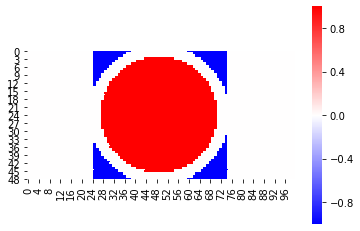

In [11]:
X_star = np.fromfunction(lambda i, j: np.where((25 <= j) & (j <= 74), (24**2 - (i+1-25)**2 - (j+1-50)**2)/100, 0), (50,100)) # like ternary
X_star *= (np.abs(X_star) > 1)
ax = sns.heatmap(X_star, vmin = -1, vmax = 1, cmap = 'bwr',square=True)

In [10]:
nsims = 100
n, d = X_star.shape
sims = np.empty((nsims, n, d))
for i in range(nsims):
    sims[i] = X_star + np.random.randn(n, d)

In [11]:
sims_copy = copy.deepcopy(sims)
layers = 8
ssvd_estimates = np.empty((layers, nsims, n, d))
for i in range(layers):
    ssvd_predictions = np.array(list(map(lambda x : x[2] * x[0] @ x[1].T, map(lambda x : ssvd(x, tol = 1e-3, max_iter = 40), sims_copy))))
    ssvd_estimates[i] = ssvd_predictions
    sims_copy -= ssvd_predictions

In [12]:
svd_decomps = list(map(lambda x : np.linalg.svd(x, full_matrices = False), sims_copy))
svd_estimates = np.empty((layers, nsims, n, d))
for i in range(layers):
    svd_estimates[i] = np.array(list(map(lambda x : x[1][i] * x[0][:,i][:,None] @ x[2][i,:][None,:],svd_decomps)))

In [13]:
for i in range(1, layers):
    ssvd_estimates[i] += ssvd_estimates[i-1]
    svd_estimates[i] += svd_estimates[i-1]

In [14]:
ssvd_classification = []
ssvd_fro = []
svd_classification = []
svd_fro = []
X_star_labels = X_star == 0
for i in range(layers):
    # Unsure how to get frobenius distance values... 4000?
    ssvd_fro.append(np.mean(list(map(np.linalg.norm, ssvd_estimates[i] - X_star))))
    svd_fro.append(np.mean(list(map(np.linalg.norm, svd_estimates[i] - X_star))))
    ssvd_classification.append(np.mean(list((map(lambda x : np.mean((x == 0) == X_star_labels), ssvd_estimates[i])))))
    svd_classification.append(np.mean(list((map(lambda x : np.mean((x == 0) == X_star_labels), svd_estimates[i])))))

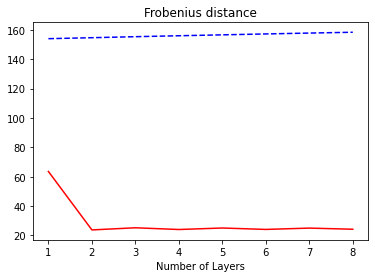

In [15]:
plt.plot(np.arange(1,9), ssvd_fro, label = "SSVD", color = "red")
plt.plot(np.arange(1,9), svd_fro, label = "SVD", color = "blue", linestyle = "dashed")
plt.xlabel("Number of Layers")
plt.title("Frobenius distance");

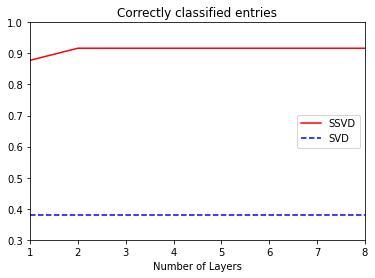

In [16]:
plt.plot(np.arange(1,9), ssvd_classification, label = "SSVD", color = "red")
plt.plot(np.arange(1,9), svd_classification, label = "SVD", color = "blue", linestyle = "dashed")
plt.xlabel("Number of Layers")
plt.ylim([0.3, 1])
plt.xlim([1, 8])
plt.title("Correctly classified entries")
plt.legend();

In [ ]:
# ToDo: Apply RoBiC, Figure out Frobenius distance, and compare with Figure 5

# Company Financial Fraud Data

In [4]:
X_com = np.loadtxt('company.txt').T

In [5]:
u1, v1, s1 = ssvd(X_com)
X_com -= s1*(u1 @ v1.T)
u2, v2, s2 = ssvd(X_com)
X_com -= s2*(u2 @ v2.T)
u3, v3, s3 = ssvd(X_com)

group_indices 

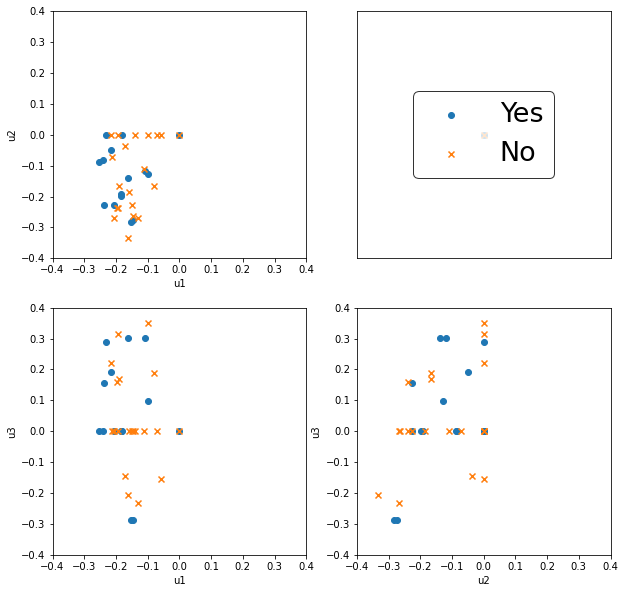

In [10]:
group_indices = [np.arange(), np.arange(15,35)]
markers = ["o", "x"]
labels = ["Yes", "No"]
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for row in axs:
    for ax in row:
        ax.set_xlim([-0.4, 0.4])
        ax.set_ylim([-0.4, 0.4])
for i in range(len(group_indices)):
    group = group_indices[i]
    axs[0,0].scatter(u1[group], u2[group], marker = markers[i])
    axs[1,0].scatter(u1[group], u3[group], marker = markers[i])
    axs[1,1].scatter(u2[group], u3[group], marker = markers[i])
    axs[0,1].scatter(0, 0, marker = markers[i], label = labels[i])
axs[0,1].legend(loc = 10, fontsize=27).get_frame().set_edgecolor('black')
axs[0,0].set_xlabel("u1")
axs[1,0].set_xlabel("u1")
axs[1,1].set_xlabel("u2")
axs[0,0].set_ylabel("u2")
axs[1,0].set_ylabel("u3")
axs[1,1].set_ylabel("u3")
axs[0,1].set_yticks(()) 
axs[0,1].set_xticks(());

In [20]:
def get_X_for_plotting(u, v, s):
    group_indices = [np.arange(15), np.arange(15,35)]
    for group in group_indices:
        u[group] = np.sort(u[group], axis = 0)

    v_nonzero = v[np.argsort(np.abs(v), axis = 0).flatten()]
    v = np.sort(v_nonzero, axis = 0)
    return s * u @ v.T

In [21]:
X1 = get_X_for_plotting(u1, v1, s1)
X2 = get_X_for_plotting(u2, v2, s2)
X3 = get_X_for_plotting(u3, v3, s3)
max_val = np.max(np.abs(np.c_[X1,X2,X3]))
# rescale for increased contrast due to differing colormap
rescale = 3
X1 /= max_val/rescale
X2 /= max_val/rescale
X3 /= max_val/rescale

In [47]:
def plot_comp(X, title, ax_given, cbar_ax, yticklabels):
    ax = sns.heatmap(X, vmin = -1, vmax = 1, cmap = 'bwr', ax = ax_given, cbar_ax = cbar_ax)
    ax.hlines([15], *ax.get_xlim(), linestyle=':', color = 'sienna')
   # ax.vlines([xticks[0], xticks[1]], *ax.get_xlim(), linestyle=':', color = 'sienna')
    #ax.set_xticks((xticks[0], xticks[1])) 
    #ax.set_xticklabels((str(xticks[0]), str(xticks[1])), rotation = 0)
    ax.set_yticks((10,50)) 
    ax.set_yticklabels(yticklabels) 
    ax.set_title(title)
    ax.set_xlabel("Company index");

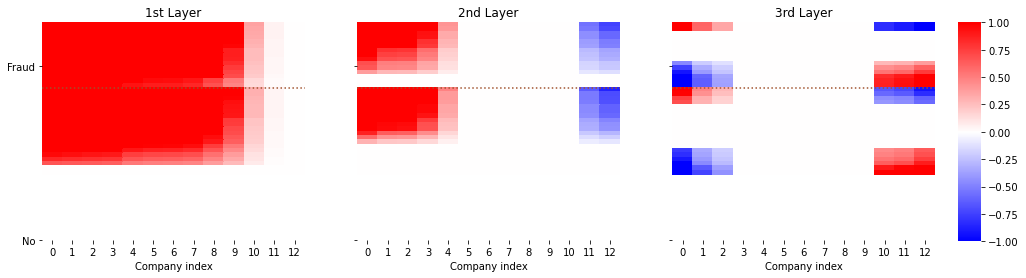

In [48]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16, 4))
cbar_ax = fig.add_axes([.92, .12, .02, 0.76])
plot_comp(X1, "1st Layer", ax1, cbar_ax, ("Fraud", "No"))
plot_comp(X2, "2nd Layer", ax2, cbar_ax, ())
plot_comp(X3, "3rd Layer", ax3, cbar_ax, ())